In [1]:
#do not run unless tensorflow can't find cuda
import os
os.environ['CUDA_DIR'] = "/usr/lib/cuda"
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/lib/cuda"

# Setup

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
# import tensorflow_probability as tfp
import time

2024-04-28 19:36:02.892804: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-28 19:36:02.914669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 19:36:02.914685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 19:36:02.915534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 19:36:02.919793: I tensorflow/core/platform/cpu_feature_guar

# Load Dataset

We load the training data and apply some flips and rotations to augment it.

In [3]:
import os
import os.path as osp
import cv2
import numpy as np
import pandas as pd

path = '../padded_seg2ct3'

images = []

for image_file in os.listdir(path):

    img = cv2.imread(osp.join(path, image_file), cv2.IMREAD_GRAYSCALE)
    
    imgflipleft = cv2.flip(img, 1)

    imgflipup = cv2.flip(img, 0)

    imgrot180 = cv2.rotate(img, cv2.ROTATE_180)
    images.append(img)

    images.append(imgflipleft)
    images.append(imgflipup)
    images.append(imgrot180)
        
images = np.array(images)

In [4]:
images.shape

(34552, 128, 128)

Normalize by dividing by max sinse sigmoid is applied to the last layer of the VAE decoder.

In [5]:
images = (images) / 255

In [6]:
images = images.reshape(images.shape[0], 128, 128, 1).astype('float32')

Train test split the data to ensure the model is not overfitting while training

In [7]:
import numpy
np.random.seed(0)
numpy.random.shuffle(images)
train_index = int(0.8*(images.shape[0]))
train_images, test_images = images[:train_index,:], images[train_index:,:]

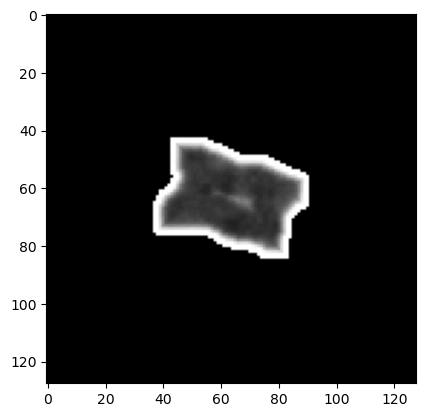

In [8]:
plt.imshow(train_images[0], cmap='gray')

In [9]:
train_size = train_images.shape[0]
batch_size = 16
test_size = test_images.shape[0]

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

2024-04-28 19:36:17.970005: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 19:36:17.997663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-28 19:36:17.997818: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Define the VAE

Encoder and decoder with some helper functions. The encoder outputs the mean and logstd, reparameterizition happens, then the decoder takes the vector sampled from the normal distribution and attempts to reconstruct the input.

In [11]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
  def generate(self, mean, logvar):
    z = self.reparameterize(mean, logvar)
    x_logit = self.decode(z, apply_sigmoid=True)
    return x_logit

# Define the Loss and Training Step

Originally the ELBO loss was used. We used the KL-divergence since we understood it better.

In [12]:
optimizer = tf.keras.optimizers.Adam(0.25*1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  reconstruction_loss = tf.reduce_mean(
      tf.reduce_sum(
          tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x),
          axis=(1, 2, 3),
      )
  )
  kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.square(tf.exp(logvar)))
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  total_loss = reconstruction_loss + kl_loss
  return total_loss


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [13]:
epochs = 2000
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)


In [14]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.show()


In [15]:
def plot_real_images(test_sample):
  
  fig = plt.figure(figsize=(4, 4))

  for i in range(test_sample.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(numpy.reshape(test_sample[i], (128,128)), cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.show()

**Plot FIDs**

In [16]:
def plot_fids(fids):
    plt.plot(fids)
    plt.title('FIDs')
    plt.ylabel('FID')
    plt.xlabel('epoch')
    plt.show()

**Plot Learning Curves**

In [17]:
def learning_curves(genrator_list_of_losses,discriminator_list_of_losses):
    plt.plot(genrator_list_of_losses)
    plt.plot(discriminator_list_of_losses)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

**Calculate FID**

In [18]:
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
from skimage.transform import resize
from numpy import asarray
from numpy.random import randint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

def fid(generator,images):
    generated_images = []
    for i in range(1000):
        noise_mean = tf.random.normal([1, latent_dim])
        noise_logvar = tf.random.normal([1, latent_dim])
        generated_images.append(np.array(generator.generate(noise_mean, noise_logvar)).reshape((128,128,1)))

    generated_images = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in generated_images])
    images = np.array([cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in images])
    
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
    def calculate_fid(model, images1, images2):
        # calculate activations
        act1 = model.predict(images1)
        act2 = model.predict(images2)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)
    
    images1 = scale_images(images, (75,75,3))
    images2 = scale_images(generated_images, (75,75,3))

    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    fid = calculate_fid(model, images1, images2)
    
    del model
    del generated_images
    
    return fid

**Pick samples from test set to draw reconstruction off later**

In [19]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

**Training Loop**

Plot fids, learning curves, and reconstructions as well.

Epoch: 627, Test set Loss: 789.6723022460938, time elapse for current epoch: 4.434612989425659


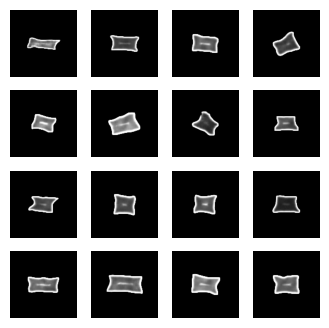

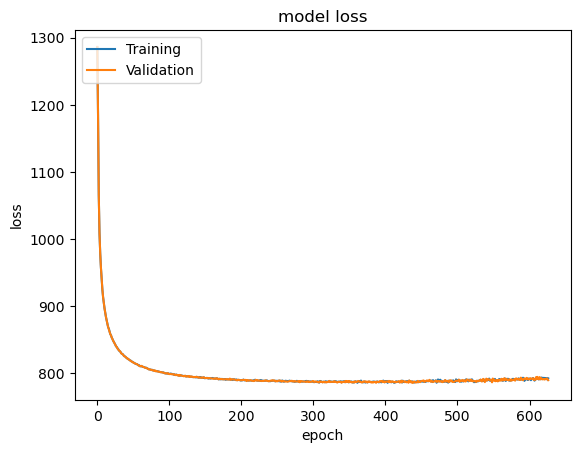

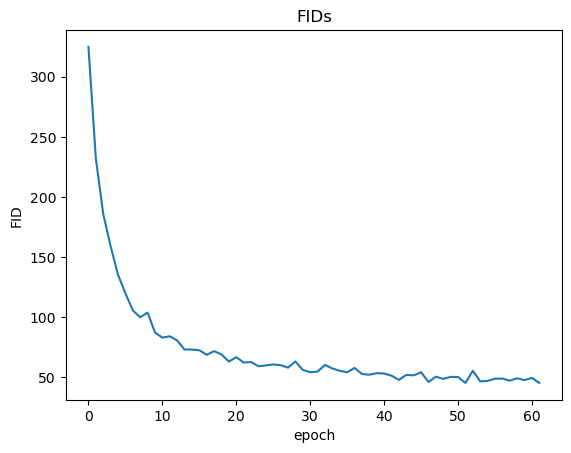

KeyboardInterrupt: 

In [20]:
train_losses = []
val_losses = []
fids = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for train_x in test_dataset:
    loss(compute_loss(model, train_x))
  elbo_train = loss.result()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo_test = loss.result()
  train_losses.append(elbo_train)
  val_losses.append(elbo_test)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set Loss: {}, time elapse for current epoch: {}'
        .format(epoch, elbo_test, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)
  learning_curves(train_losses,val_losses)
  if (epoch) % 10 == 0:
        fids.append(fid(model,images))
  plot_fids(fids)

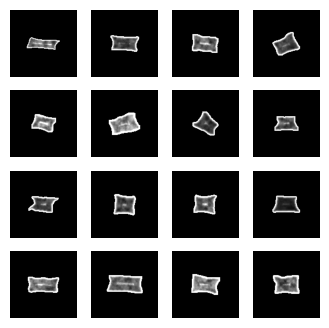

In [22]:
plot_real_images(test_sample)

In [27]:
seed = tf.random.normal([num_examples_to_generate, latent_dim])
seed2 = tf.random.normal([num_examples_to_generate, latent_dim])

In [28]:
def generate_and_save_images2(model, epoch, test_mean, test_log_var):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  z = model.reparameterize(test_mean, test_log_var)
  predictions = model.sample(z)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :], cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

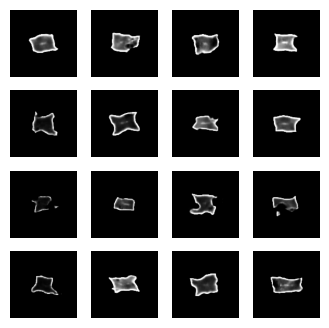

In [29]:
generate_and_save_images2(model,
                             epoch + 1,
                             seed, seed2)

## Save the models, the loss and FID curves.

In [21]:
import csv
with open('vae_train_loss_synthetic_cts.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(train_losses)
with open('vae_validation_loss_synthetic_cts.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(val_losses)
with open('FIDs_vae_validation_synthetic_cts.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(fids)

In [31]:
model.save_weights('./synthetic_cts_var_ae')